In [1]:
from ipy_oxdna.umbrella_sampling import MeltingUmbrellaSampling
from ipy_oxdna.oxdna_simulation import SimulationManager

import numpy as np
import pandas as pd
import os
from os.path import join
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'no-latex', 'bright'])

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.

****** PyMBAR will use 64-bit JAX! *******
* JAX is currently set to 32-bit bitsize *
* which is its default.                  *
*                                        *
* PyMBAR requires 64-bit mode and WILL   *
* enable JAX's 64-bit mode when called.  *
*                                        *
* This MAY cause problems with other     *
* Uses of JAX in the same code.          *
******************************************



In [2]:
path = os.path.abspath('./')

file_dir_name = 'oxdna_files'  #'NAME_OF_DIR_CONTAINING_OXDNA_DAT_TOP'
file_dir = join(path, file_dir_name) #f'{path}/{file_dir_name}'

sim_dir_name = '8_nt_duplex_melting_tutorial' #'CHOSEN_NAME_WHERE_SIMULATION_WILL_BE_STORED'
sim_dir = join(file_dir, sim_dir_name)   #f'{path}/{sim_dir_name}'

# Initialize the umbrella sampling object, this will create the simulation directory

# Clean build has 3 options, False, True and 'force' False will not allow you to overwrite
# existing simulation directories, True will overwrite existing simulation directories after asking for confirmation
# 'force' will overwrite existing simulation directories without asking for confirmation
us = MeltingUmbrellaSampling(file_dir, sim_dir, clean_build=True)

# The simulation manager object is used to run the simulation is non-blocking subprocesses,
# and will optimally allocate the simulations to available resources
simulation_manager = SimulationManager()

# Indexes of nucleotides to apply forces to and measure distance between (Order Parameter(OP))
com_list = '8,9,10,11,12,13,14,15'
ref_list = '7,6,5,4,3,2,1,0'

# Order of input nucleotides is import to collect the hb_contacts CV correctly, irrelevant for all else
com_list = ','.join(sorted(com_list.split(','), key=int)[::-1])
ref_list = ','.join(sorted(ref_list.split(','), key=int))

# Minimum and maximum distance between nucleotides the simulations will attempt to pull the OP 
xmin = 0
xmax = 15

# Number of simulation windows/replicas
n_windows = 50

# Stiffness of the COM harmonic bias potential
stiff = 3

# Temperature of the simulation
temperature = "40C"

# Starting_r0 is only relevant if you run the pre_equlibration step,
# needed if you have large stiffness values and range of the OP is large but dosen't hurt to always run quickly
# Not possible to know before you run the simulation but you can run a till they print once,
# terminate and paste the starting_r0 value from the output file
starting_r0 = 0.4213

# Frequecny of printing the CVs to file
print_every = 1e4

# Name of file to save all but one of the CVs to, it is possible this cannot be changed
obs_filename = 'all_observables.txt'

# Name of file to save the hb_contacts CV to
hb_contact_filename = 'hb_contacts.txt'

# Number of simulation steps to run for each window
pre_eq_steps = 1e6  # This only need to short
eq_steps = 5e6  # This needs to be long enough to equilibrate the system
prod_steps = 2e8 # This needs to be long enough to get converged free energy profiles (methods to check are provided)

# Setup the custom hb_contacts CV
particle_indexes = [com_list, ref_list]
hb_contact_observable = [{'idx':particle_indexes, 'name':f'{hb_contact_filename}', 'print_every':int(print_every)}]

# oxDNA Simulation parameters
pre_equlibration_parameters = {
    'backend':'CPU', 'steps':f'{pre_eq_steps}','print_energy_every': f'{pre_eq_steps // 10}',
    'print_conf_interval':f'{pre_eq_steps // 2}', "CUDA_list": "no",'use_edge': 'false',
    'refresh_vel': '1','fix_diffusion': '0', 'T':f'{temperature}'}

equlibration_parameters = {
    'backend':'CPU','steps':f'{eq_steps}','print_energy_every': f'{eq_steps// 10}',
    'print_conf_interval':f'{eq_steps // 2}', "CUDA_list": "no",'use_edge': 'false',
    'refresh_vel': '1', 'fix_diffusion': '0', 'T':f'{temperature}'}

production_parameters = {
    'backend':'CPU', 'steps':f'{prod_steps}','print_energy_every': f'{prod_steps}',
    'print_conf_interval':f'{prod_steps}', "CUDA_list": "no", 'use_edge': 'false',
    'refresh_vel': '1','fix_diffusion': '0', 'T':f'{temperature}'}


In [3]:
# This will build the pre_equlibration runs and queue them in the simulation manager

us.build_pre_equlibration_runs(
    simulation_manager, n_windows, com_list, ref_list, stiff, xmin, xmax,
    pre_equlibration_parameters, starting_r0, pre_eq_steps, continue_run=False,
    # If you want to continue a previous simulation set continue_run=int(n_steps)
    
    print_every=print_every, observable=True, protein=None, sequence_dependant=True,
    force_file=False, name=obs_filename, custom_observable=hb_contact_observable)

In [ ]:
simulation_manager.run(cpu_run=True) # This will run the simulation in the background (non-blocking)
#simulation_manager.worker_manager(cpu_run=True) # This will run the simulation in the foreground (blocking)

In [5]:
us.build_equlibration_runs(
    simulation_manager, n_windows, com_list, ref_list,
    stiff, xmin, xmax, equlibration_parameters, continue_run=False,
    
    print_every=print_every, observable=True, protein=None, name=obs_filename,
    force_file=False, custom_observable=hb_contact_observable)

In [ ]:
simulation_manager.run(cpu_run=True)

In [9]:
us.build_production_runs(
    simulation_manager, n_windows, com_list, ref_list,
    stiff, xmin, xmax, production_parameters, continue_run=False,
    
    observable=True, print_every=print_every, protein=None, name=obs_filename,
    force_file=False, custom_observable=hb_contact_observable)

In [ ]:
simulation_manager.run(cpu_run=True)

In [ ]:
simulation_manager.terminate_all()

,com_distance,hb_list,force_energy_0,force_energy_1,kinetic_energy,backbone,bonded_excluded_volume,stacking,nonbonded_excluded_volume,hydrogen_bonding,cross_stacking,coaxial_stacking,debye_huckel,steps,hb_contact
0,0.2833,8.0,0.000026,0.000026,0.302649,0.022302,0.0,-1.056571,0.0,-0.336264,-0.108381,0.0,0.001267,0,0.999999
1,0.4158,8.0,0.001258,0.001258,0.274739,0.030432,0.0,-1.008309,0.0,-0.280447,-0.096421,0.0,0.000823,10000,0.999999
2,0.3583,8.0,0.000319,0.000319,0.267661,0.034034,0.0,-0.986964,0.0,-0.320877,-0.078172,0.0,0.001390,20000,0.999997
3,0.4713,7.0,0.002751,0.002751,0.326519,0.056746,0.0,-1.044492,0.0,-0.300849,-0.096227,0.0,0.000749,30000,0.999999
4,0.3849,8.0,0.000676,0.000676,0.288251,0.040523,0.0,-1.010004,0.0,-0.335284,-0.109314,0.0,0.001096,40000,0.999997


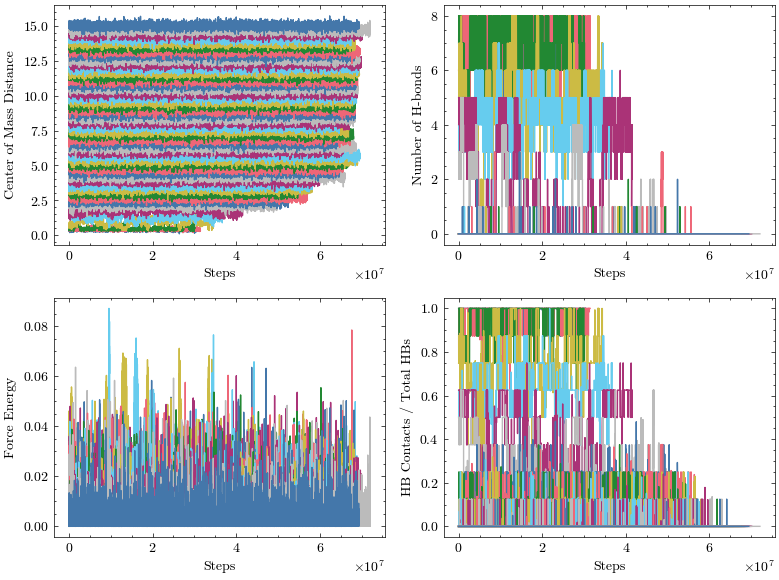

In [41]:
# Read collected variable into us.obs_df a list of n_windows dataframes
# The number of datapoints can vary between windows during run time, disallowing arrays
sim_type = 'prod' # 'pre_eq', 'eq', 'prod'
us.analysis.read_all_observables(sim_type) 
# us.read_hb_contacts(sim_type)


us.analysis.plot_melting_CVs(rolling_window=1)
display(us.obs_df[0].head())

In [ ]:
# This will provide access to the pre_equlibration simulations information
pre_eq_sims = us.equlibration_sims
# us.equlibration_sims, us.production_sims are also available

# View conf interactivly in jupyter notebook
pre_eq_sims[0].analysis.view_last() # .view_init(), .view_conf(conf_number), .get_conf_count()

# Plot the energy of the pre_equlibration simulations
fig, ax = plt.subplots(figsize=(8, 6))
for sim in pre_eq_sims:
    sim.analysis.plot_energy(fig=fig, ax=ax)
plt.legend()


In [29]:
temp_range = np.arange(20, 70, 2)
# temp_range = np.array([52])
n_bins = 50
xmin = 0
xmax = 15
max_hb = 8
umbrella_stiff = 3
epsilon = 1e-7
convergence_slice = 2

us.wham_cont_and_disc_temp_interp_converg_analysis(
    convergence_slice, temp_range,
    n_bins, xmin, xmax, umbrella_stiff, max_hb,
    epsilon=epsilon, reread_files=False)

WHAM | 17000/? [00:39<00:00, 432.55it/s, Convergence: 0.00000012 / 1e-07]


Converged in [17323] iterations


WHAM | 19000/? [00:44<00:00, 427.97it/s, Convergence: 0.00000011 / 1e-07]


Converged in [19250] iterations
30.0
43.08617234468937
30.0
43.18236472945892


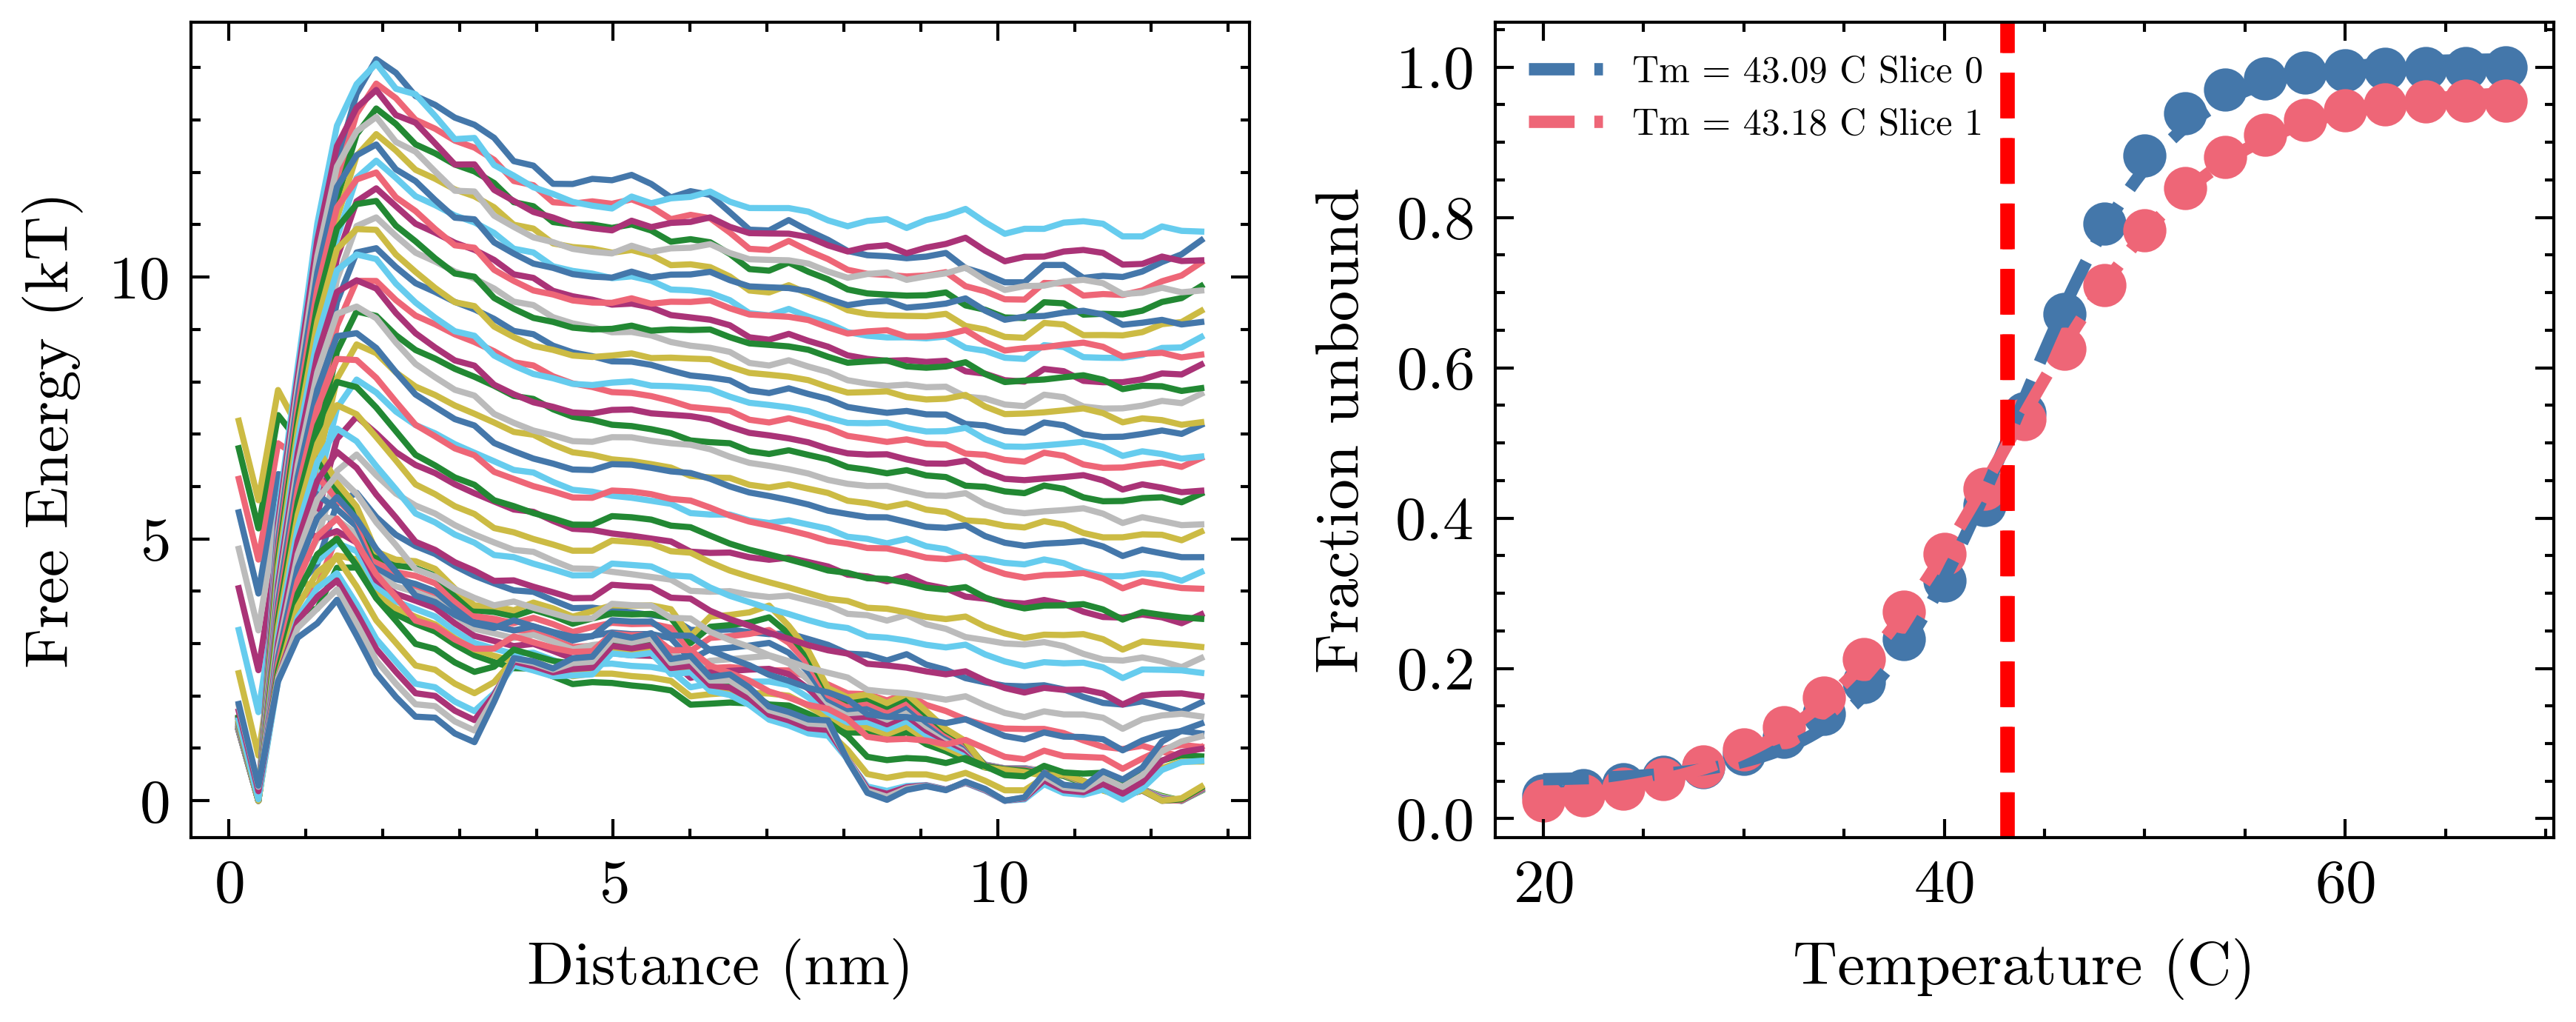

In [40]:
fig, (ax1, ax2) = plt.subplots(1,2, dpi=600, figsize=(6,2.5), tight_layout=True)

bin_centers, bin_edges = us.get_bins(xmin, xmax, n_bins=n_bins)
bin_centers = bin_centers*0.8518

for idx, free in enumerate(us.convergence_free):            
    sub_index = free[0].argmin()
    for f, temp_val in zip(free, temp_range):
        if idx == 0:
            ax1.plot(bin_centers, f, label=f'{temp_val}C WHAM Custom') 
        else:
            ax1.plot(bin_centers, f, label=f'{temp_val}C WHAM Custom')
ax1.set_xlabel('Distance (nm)')
ax1.set_ylabel('Free Energy (kT)')

for idx, (inverted_finfs, x_fit, y_fit, Tm) in enumerate(zip(us.convergence_inverted_finfs, us.convergence_x_fit, us.convergence_y_fit, us.convergence_Tm)):
    ax2.scatter(temp_range, inverted_finfs, marker='o')
    ax2.plot(x_fit, y_fit, linestyle='--', linewidth=2, label=f'Tm = {Tm:.2f} C Slice {idx}')
    ax2.axvline(x=Tm, color='r', linestyle='--', linewidth=2)#, label=f'Tm = {Tm:.2f} C')
    ax2.legend(fontsize=6)   
ax2.set_xlabel('Temperature (C)')
ax2.set_ylabel('Fraction unbound')
fig.tight_layout()

In [ ]:
# You will need to reinitalize the observables if you did not build the dirs in your current kernel, I want to fix this
us.observables_list = []
us.initialize_observables(com_list, ref_list, print_every=print_every, name=obs_filename)


us.pymbar.run_mbar_fes(
    reread_files=True,
    sim_type='prod',
    restraints=False,
    force_energy_split=False)

max_hb = 8
temp_range = np.array([42, 52, 62])

free_n_hb, bin_n_hb, dfree_n_hb = us.pymbar.n_hb_fes_hist(max_hb, temp_range=temp_range)
free_i_com, bin_com, dfree_com = us.pymbar.com_fes_hist(n_bins=20, temp_range=temp_range)
free_hb_contact, bin_hb_contact, dfree_hb_contact = us.pymbar.hb_contact_fes_hist(temp_range=temp_range)

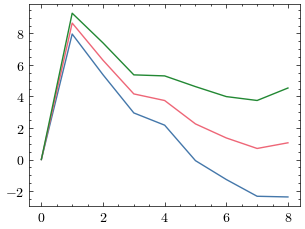

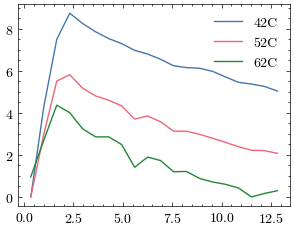

In [18]:
plt.figure()
for idx, free in enumerate(free_n_hb):
    plt.plot(bin_n_hb, free, label=f'{temp_range[idx]}C')

plt.figure()
for idx, free in enumerate(free_i_com):
    plt.plot(bin_com, free, label=f'{temp_range[idx]}C')
plt.legend()